In [1]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.applications import ResNet50

In [2]:
MODEL_NAME = "M_CNN_M1_10_20.h5"
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/processed_data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 40
NUM_EPOCHS = 100
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [3]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [4]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [5]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.5, 
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

In [6]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [7]:
train_generator.samples 

2297

In [8]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [10]:

def create_resnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights="imagenet", pooling='max')

    for layer in base_model.layers:
        layer.trainable = False
        
        

    model = Sequential()
    model.add(base_model)
    model.add(Dense)
    model.add(Dense(4, activation='softmax'))

    #model = Sequential()
    #model.add(base_model)
    #model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    #model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
def step_decay(epoch):
   initial_lrate = 0.5
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:

callbacks_list  = [lr_scheduler]

In [14]:
model = create_resnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.5.
Epoch 1/100
58/58 [==============================] - 159s 3s/step - loss: 2469.0974 - accuracy: 0.3100 - val_loss: 2175.1584 - val_accuracy: 0.2862

Epoch 00002: LearningRateScheduler reducing learning rate to 0.5.
Epoch 2/100
58/58 [==============================] - 154s 3s/step - loss: 1723.8516 - accuracy: 0.3226 - val_loss: 1769.2203 - val_accuracy: 0.4782

Epoch 00003: LearningRateScheduler reducing learning rate to 0.5.
Epoch 3/100
58/58 [==============================] - 153s 3s/step - loss: 945.8426 - accuracy: 0.3853 - val_loss: 2026.5354 - val_accuracy: 0.3508

Epoch 00004: LearningRateScheduler reducing learning rate to 0.5.
Epoch 4/100
58/58 [==============================] - 151s 3s/step - loss: 1165.4147 - accuracy: 0.3957 - val_loss: 714.0137 - val_accuracy: 0.4782

Epoch 00005: LearningRateScheduler reducing learning rate to 0.5.
Epoch 5/100
58/58 [==============================] - 164s 3s/step - loss: 8

58/58 [==============================] - 141s 2s/step - loss: 53.5128 - accuracy: 0.6495 - val_loss: 100.2582 - val_accuracy: 0.4572

Epoch 00040: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 40/100
58/58 [==============================] - 141s 2s/step - loss: 46.7587 - accuracy: 0.6526 - val_loss: 83.9450 - val_accuracy: 0.5166

Epoch 00041: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 41/100
58/58 [==============================] - 141s 2s/step - loss: 50.4166 - accuracy: 0.6465 - val_loss: 88.5937 - val_accuracy: 0.4764

Epoch 00042: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 42/100
58/58 [==============================] - 141s 2s/step - loss: 52.1646 - accuracy: 0.6352 - val_loss: 89.5262 - val_accuracy: 0.4921

Epoch 00043: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 43/100
58/58 [==============================] - 141s 2s/step - loss: 45.2753 - accuracy: 0.6639 - val_loss: 77.1880 - val_accuracy: 0.4869

Ep

58/58 [==============================] - 138s 2s/step - loss: 36.1598 - accuracy: 0.6713 - val_loss: 67.2368 - val_accuracy: 0.5428

Epoch 00078: LearningRateScheduler reducing learning rate to 0.00390625.
Epoch 78/100
58/58 [==============================] - 140s 2s/step - loss: 37.8489 - accuracy: 0.6765 - val_loss: 69.8926 - val_accuracy: 0.5253

Epoch 00079: LearningRateScheduler reducing learning rate to 0.00390625.
Epoch 79/100
58/58 [==============================] - 139s 2s/step - loss: 37.2528 - accuracy: 0.6709 - val_loss: 65.0694 - val_accuracy: 0.5358

Epoch 00080: LearningRateScheduler reducing learning rate to 0.001953125.
Epoch 80/100
58/58 [==============================] - 139s 2s/step - loss: 37.2547 - accuracy: 0.6783 - val_loss: 67.4878 - val_accuracy: 0.5567

Epoch 00081: LearningRateScheduler reducing learning rate to 0.001953125.
Epoch 81/100
58/58 [==============================] - 139s 2s/step - loss: 36.7615 - accuracy: 0.6844 - val_loss: 71.4620 - val_accurac

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

10/10 [==============================] - 17s 2s/step - loss: 276.9919 - accuracy: 0.4315
Test Accuracy: 43.14720928668976%


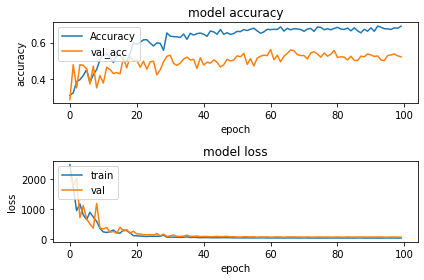

In [17]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()